In [37]:
import pandas as pd
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sys import exit as sys_exit

In [38]:
csv_path = '/Users/stamatisfrangoulis/MATH596/Project/data/ann.co2.0.csv'

    
df = pd.read_csv(csv_path)
print("Columns in df:\n", df.columns)

target_col = "#co2"
    
numeric_df = df.select_dtypes(include=["int64", "float64"]).copy()
numeric_df.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_df = numeric_df.dropna()




X = numeric_df.drop(columns=[target_col]).values
y = numeric_df[target_col].values

Columns in df:
 Index(['#co2', ' lat', ' lon', ' sst', ' sst-ave', ' sss', ' mld', ' chl',
       ' year', ' month'],
      dtype='object')


In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.001, random_state=42
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.float32).view(-1, 1)

X_mean = X_train_tensor.mean(dim=0, keepdim=True)
X_std  = X_train_tensor.std(dim=0, keepdim=True) + 1e-8

X_train_norm = (X_train_tensor - X_mean) / X_std
X_test_norm  = (X_test_tensor  - X_mean) / X_std   # apply train stats

y_mean = y_train_tensor.mean()
y_std  = y_train_tensor.std() + 1e-8

y_train_norm = (y_train_tensor - y_mean) / y_std

train_dataset = TensorDataset(X_train_norm, y_train_norm)
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [40]:
# class FFNN(nn.Module):
#     def __init__(self, input_size, hidden_sizes=[128, 64, 32], output_size=1, dropout_p=0.2):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_size, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, 1)
#         )
#     def forward(self, x):
#         return self.net(x)



In [41]:
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], dropout_p=0.2):
        super().__init__()
        layers = []
        in_dim = input_size

        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_p))
            in_dim = h

        layers.append(nn.Linear(in_dim, 1))  # output
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [42]:
input_size=X_train_tensor.shape[1]
hidden_size=36
output_size=1

model = FFNN(input_size, hidden_sizes=[128, 64, 32])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:


num_epochs = 10
torch.manual_seed(1)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for features, targets in train_dl:
        outputs = model(features)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * features.size(0)

    epoch_loss = running_loss / len(train_dl.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.10f}")


Epoch [1/10], Loss: 0.5522035176
Epoch [2/10], Loss: 0.4618229059
Epoch [3/10], Loss: 0.4392276115
Epoch [4/10], Loss: 0.4256591223
Epoch [5/10], Loss: 0.4147629972
Epoch [6/10], Loss: 0.4094330400
Epoch [7/10], Loss: 0.4062162576
Epoch [8/10], Loss: 0.4021215758
Epoch [9/10], Loss: 0.3977315911
Epoch [10/10], Loss: 0.3965924185


In [44]:
model.eval()
with torch.no_grad():

    y_pred_norm = model(X_test_norm)


    y_pred = y_pred_norm * y_std + y_mean

    y_pred_np = y_pred.squeeze().cpu().numpy()
    y_actual_np = y_test_tensor.squeeze().cpu().numpy()


test_mse = np.mean((y_pred_np - y_actual_np) ** 2)
test_rmse = np.sqrt(test_mse)

print("\n--- Test Results ---")
print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)


print("\nSample predictions (first 20 rows):\n")
for i in range(20):
    print(f"Row {i:2d} | Actual: {y_actual_np[i]:,.0f} | Predicted: {y_pred_np[i]:,.0f}")


--- Test Results ---
Test MSE: 296.11765
Test RMSE: 17.208069

Sample predictions (first 20 rows):

Row  0 | Actual: 334 | Predicted: 348
Row  1 | Actual: 362 | Predicted: 363
Row  2 | Actual: 360 | Predicted: 358
Row  3 | Actual: 382 | Predicted: 383
Row  4 | Actual: 351 | Predicted: 350
Row  5 | Actual: 436 | Predicted: 406
Row  6 | Actual: 360 | Predicted: 362
Row  7 | Actual: 329 | Predicted: 339
Row  8 | Actual: 318 | Predicted: 317
Row  9 | Actual: 355 | Predicted: 345
Row 10 | Actual: 373 | Predicted: 377
Row 11 | Actual: 311 | Predicted: 326
Row 12 | Actual: 329 | Predicted: 326
Row 13 | Actual: 339 | Predicted: 351
Row 14 | Actual: 379 | Predicted: 383
Row 15 | Actual: 346 | Predicted: 357
Row 16 | Actual: 387 | Predicted: 381
Row 17 | Actual: 379 | Predicted: 381
Row 18 | Actual: 313 | Predicted: 318
Row 19 | Actual: 354 | Predicted: 349


In [45]:
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# Plot the world map
fig, ax = plt.subplots(figsize=(10, 6))
world.plot(ax=ax, color='lightgray', edgecolor='black')

ax.set_title("World Map")
ax.set_xticks([])
ax.set_yticks([])
x=(np.linspace(0,1,100))
values = np.array(columns_dict['SST_AVE_UNWTD_YEAR'])
values_clean = values[~np.isnan(values)]
norm = mcolors.Normalize(vmin=np.min(values_clean), vmax=np.max(values_clean))
cmap = plt.cm.inferno
colors = cmap(norm(values))

ax.scatter(columns_dict['LON'], columns_dict['LAT'], 
           c=colors, s=2, alpha=0.6, marker='o')



plt.show()

NameError: name 'gpd' is not defined

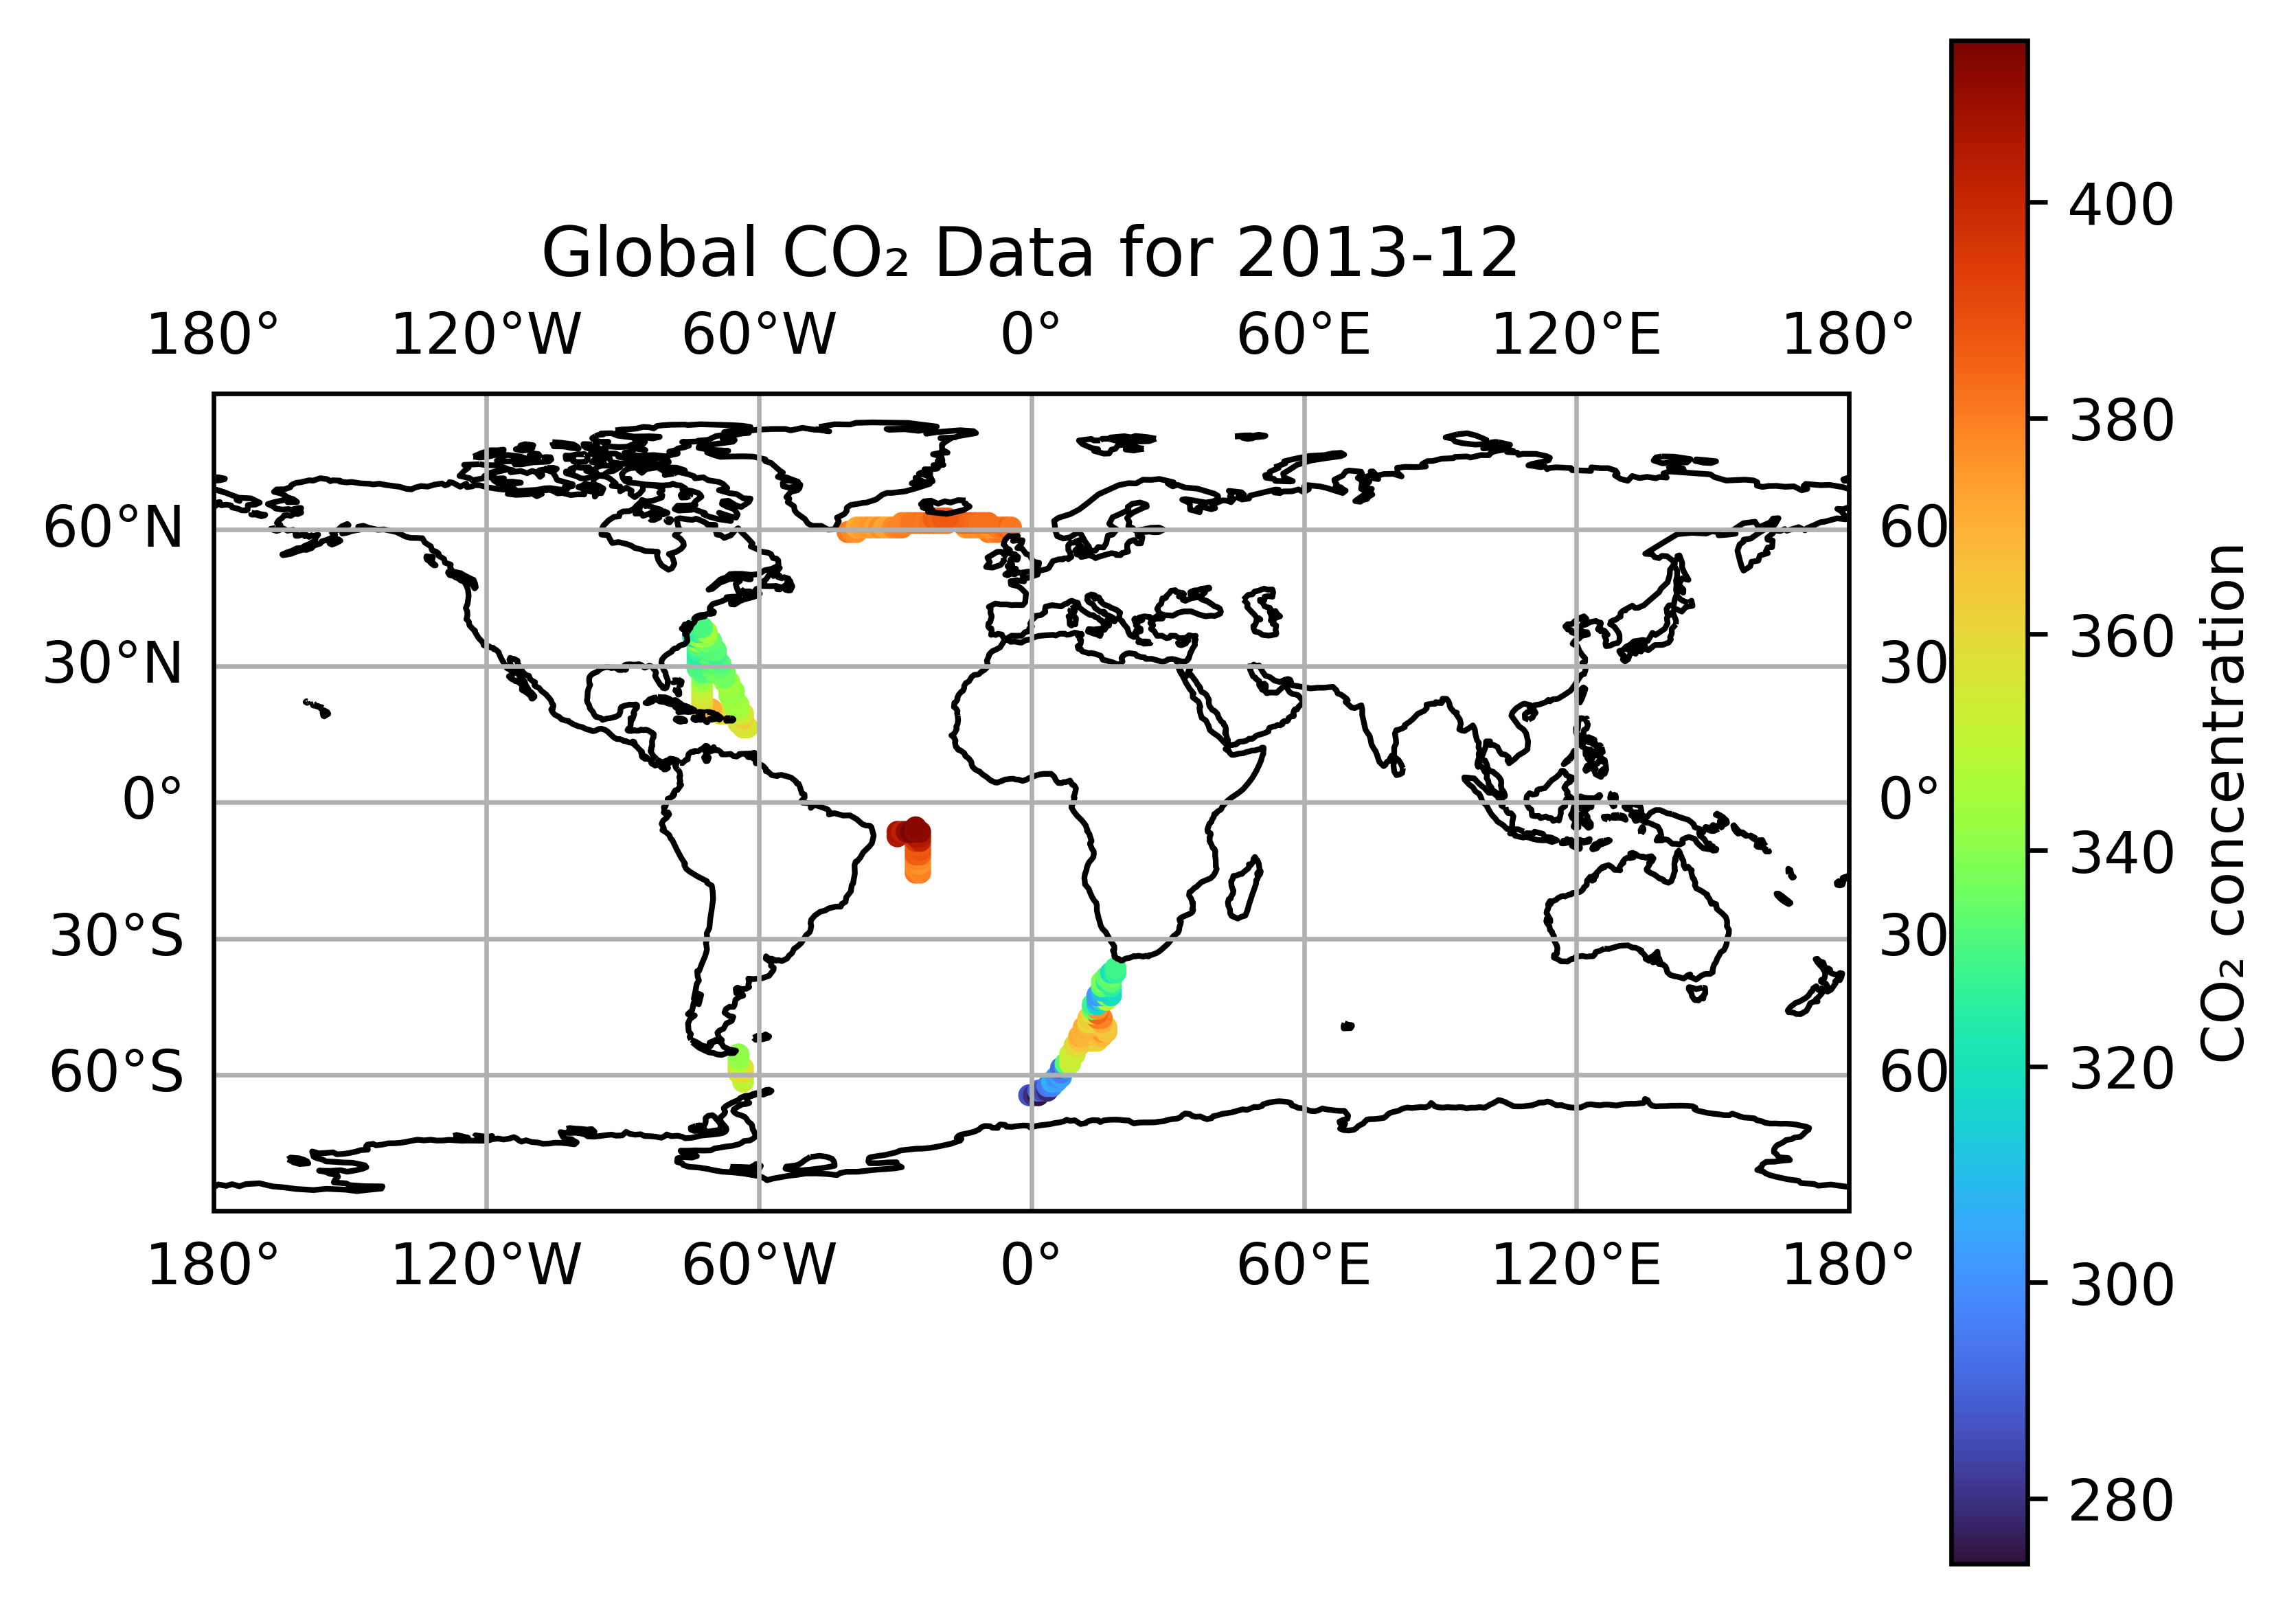

In [46]:

lon_col   = " lon"
lat_col   = " lat"
year_col  = " year"
month_col = " month"
target_col = "#co2"

year_to_select  = 2013
month_to_select = 12

# Filter by both year AND month
df_subset = df[(df[year_col] == year_to_select) &
               (df[month_col] == month_to_select)]

plt.figure(dpi=600)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)

sc = ax.scatter(
    df_subset[lon_col],
    df_subset[lat_col],
    s=8,
    c=df_subset[target_col],
    cmap="turbo",
    transform=ccrs.PlateCarree()
)

plt.colorbar(sc, label="CO₂ concentration")
plt.title(f"Global CO₂ Data for {year_to_select}-{month_to_select:02d}")
plt.show()


In [53]:

# Column names (with spaces, as in your df)
lon_col   = " lon"
lat_col   = " lat"
year_col  = " year"
month_col = " month"
target_col = "#co2"

year_to_select  = 2013
month_to_select = 12   # change this to whatever month you want

# --- Create global grid: 1° resolution (you can make this finer) ---
lon_grid = np.arange(-180, 180 + 1, 1.0)   # -180..180
lat_grid = np.arange(-89.5, 89.5 + 1, 1.0) # -89.5..89.5

LON, LAT = np.meshgrid(lon_grid, lat_grid)

# Base dataframe for prediction grid
grid_df = pd.DataFrame({
    lon_col:   LON.ravel(),
    lat_col:   LAT.ravel(),
    year_col:  year_to_select,
    month_col: month_to_select,
})


In [54]:
feature_cols = numeric_df.columns.drop(target_col)

# Fill any other feature columns with their training mean
for col in feature_cols:
    if col not in grid_df.columns:
        grid_df[col] = numeric_df[col].mean()

# Ensure column order matches training
X_grid = grid_df[feature_cols].values.astype(np.float32)

In [55]:
X_mean = X_train_tensor.mean(dim=0, keepdim=True)
X_std  = X_train_tensor.std(dim=0, keepdim=True) + 1e-8

X_mean_np = X_mean.cpu().numpy()
X_std_np  = X_std.cpu().numpy()

X_grid_norm = (X_grid - X_mean_np) / X_std_np

device = next(model.parameters()).device
X_grid_tensor = torch.tensor(X_grid_norm, dtype=torch.float32).to(device)

In [56]:
y_pred = y_pred_norm * y_std + y_mean

In [57]:
model.eval()
with torch.no_grad():
    y_grid_norm = model(X_grid_tensor)

# Convert tensors → numpy
y_grid_norm_np = y_grid_norm.cpu().numpy().squeeze()

# Un-normalize using YOUR stats
y_mean_np = y_mean.cpu().numpy()
y_std_np  = y_std.cpu().numpy()

co2_pred = y_grid_norm_np * y_std_np + y_mean_np

# Reshape back to lat/lon grid
co2_pred_grid = co2_pred.reshape(LAT.shape)

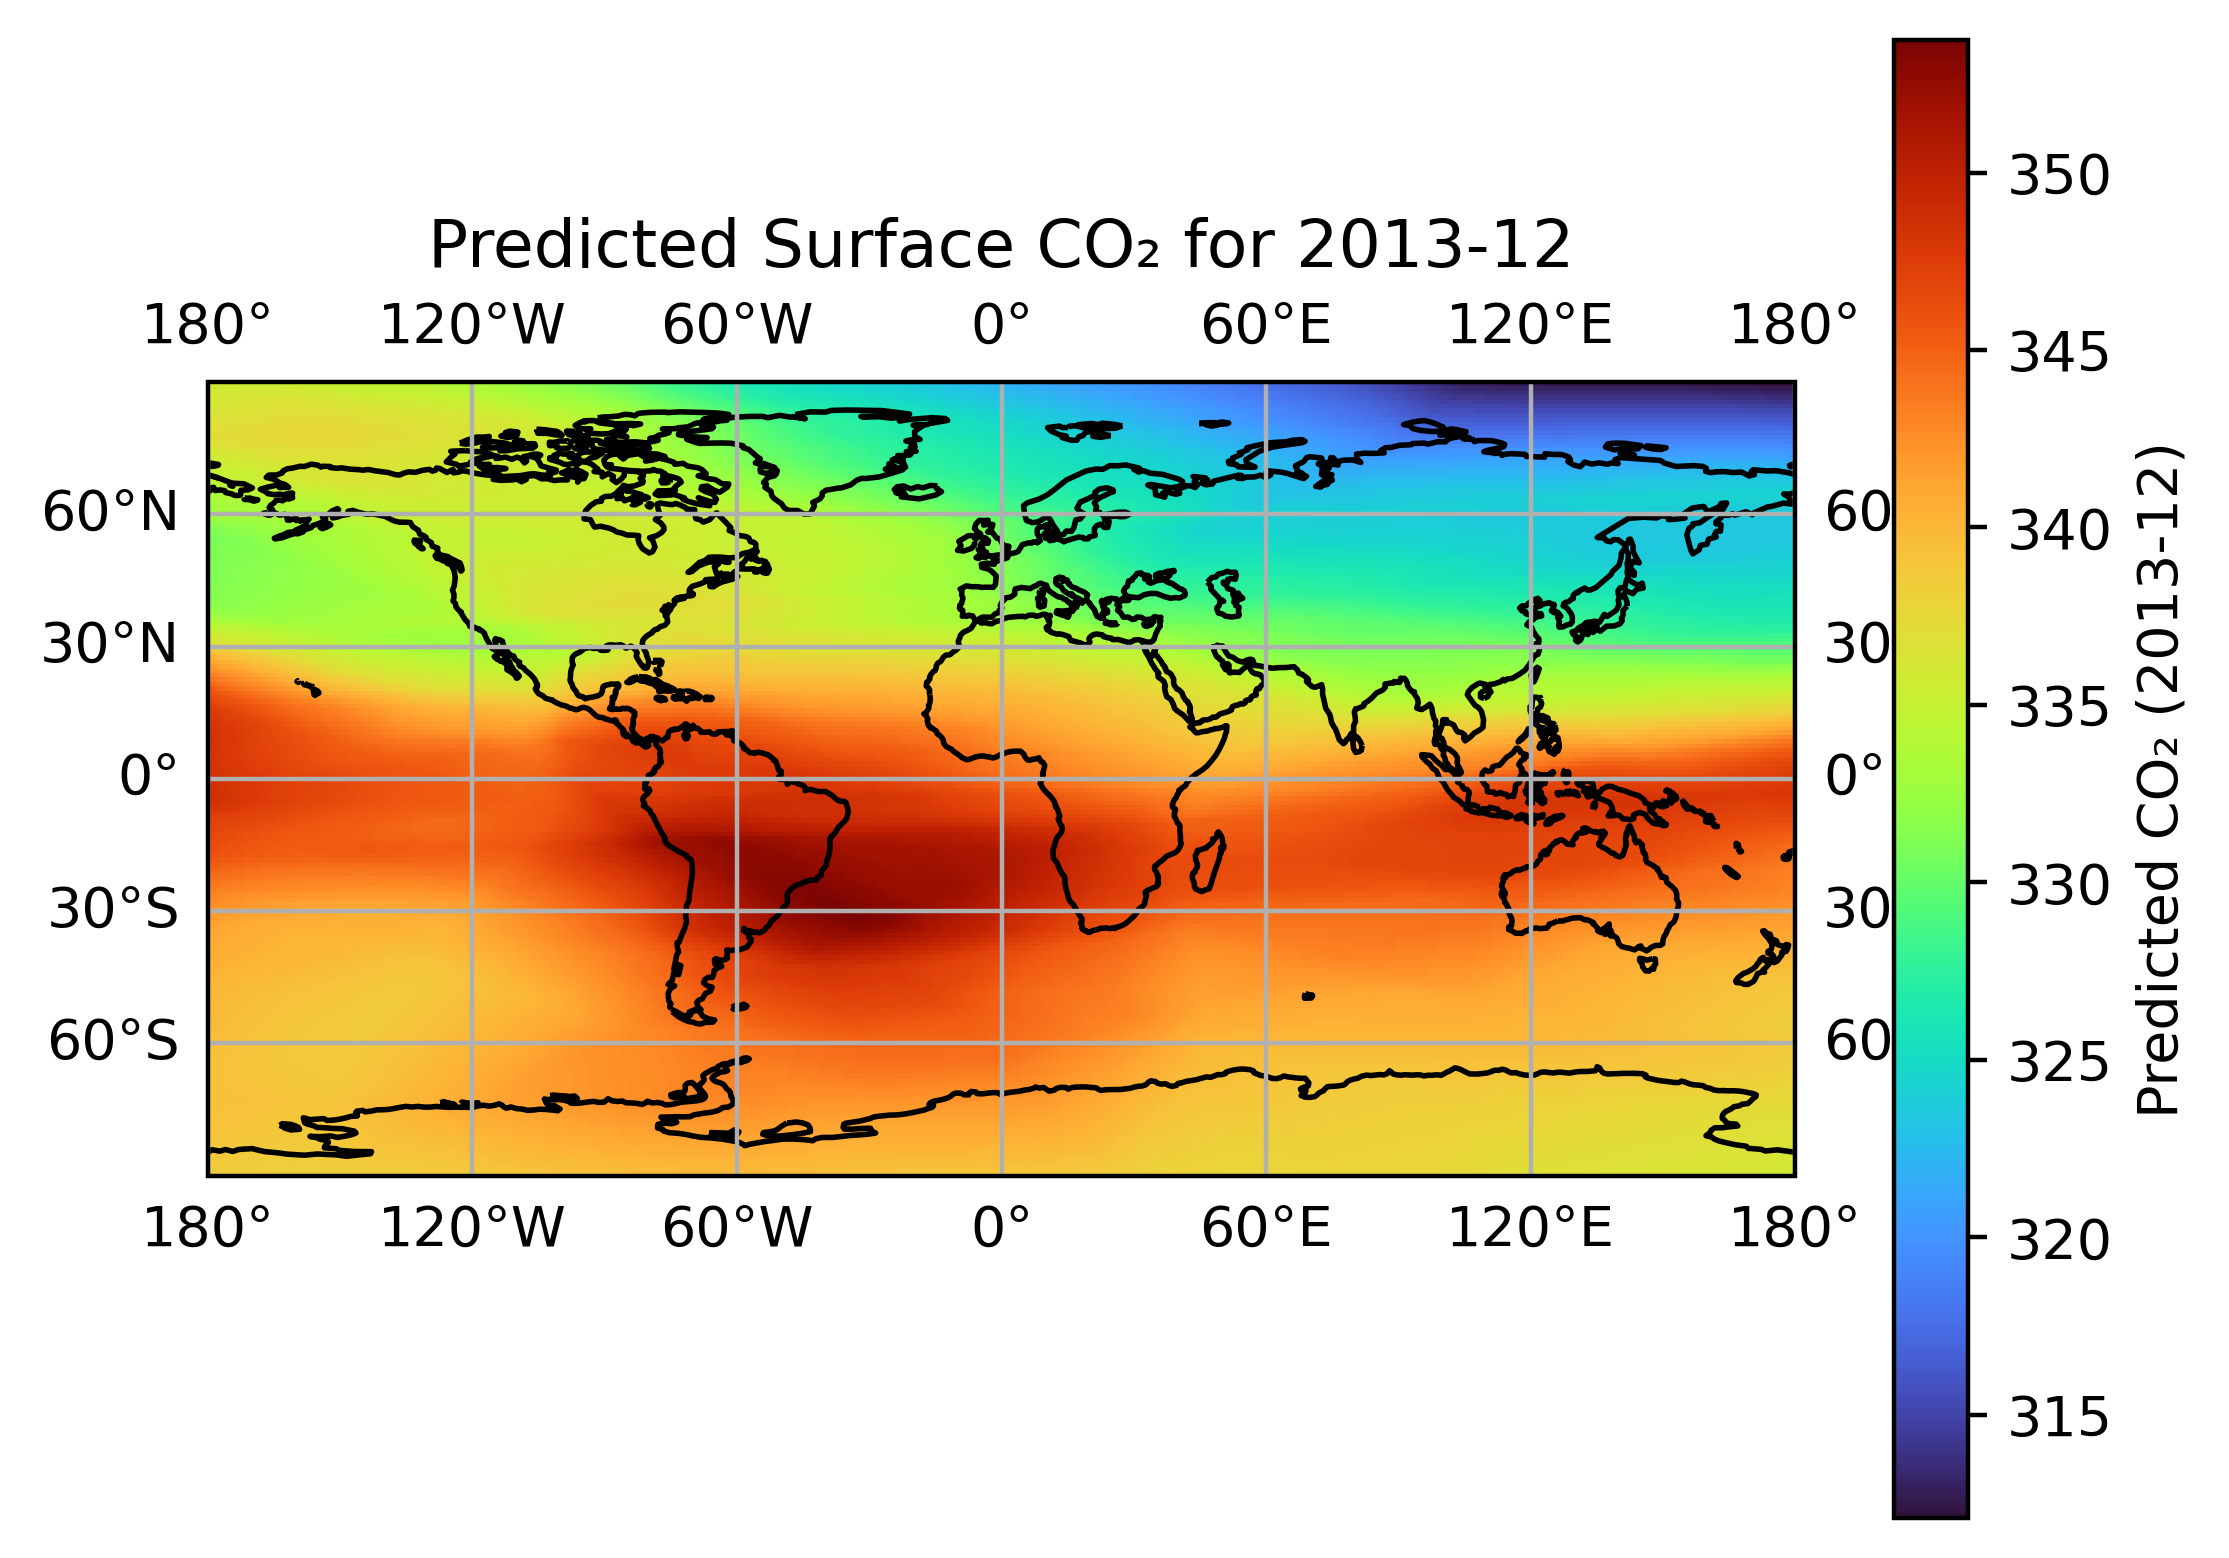

In [58]:
plt.figure(dpi=400)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)

# pcolormesh expects 1D lon/lat arrays and a 2D data array
pc = ax.pcolormesh(
    lon_grid,
    lat_grid,
    co2_pred_grid,
    cmap="turbo",
    transform=ccrs.PlateCarree()
)

plt.colorbar(pc, label=f"Predicted CO₂ ({year_to_select}-{month_to_select:02d})")
plt.title(f"Predicted Surface CO₂ for {year_to_select}-{month_to_select:02d}")
plt.show()


In [59]:
import os
current_path = os.getcwd()
print(current_path)

/Users/stamatisfrangoulis/MATH596/Project
